#Gastrointestinal Bleeding Detection CNN & ViT

Vision Transformer hakkında yazdığım Medium yazımın linkini bırakıyorum.

Vision Transformer'lar hakkında daha detaylı bilgi alabilirsiniz. Keyifli okumlar diliyorum. ✨

Medium: [Vision Transformer (ViT)](https://medium.com/@zeynepalidemirtas/vision-transformer-vit-f607c4afdde5)

In [ ]:
!nvidia-smi

Fri Jun 21 11:16:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              29W /  70W |   1145MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##CNN

In [ ]:
# Gerekli Kütüphanelerin Yüklenmesi

!pip install visualkeras
!pip install tensorflow_addons

import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Genel Parametrelerin Ayarlanması

epochs = 15
pic_size = 72
batch_size = 32
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Veri Yükleme, Hazırlama ve Görselleştirme

def load_dataset(folder_path, pic_size):
    dataset = []
    labels = []

    for class_index, class_name in enumerate(['0_normal', '1_ulcerative_colitis', '2_polyps', '3_esophagitis']):
        class_folder = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)
            image = image.resize((pic_size, pic_size))
            dataset.append(np.array(image))
            labels.append(class_index)

    return np.array(dataset), np.array(labels)

train_path = "/content/drive/MyDrive/Colab Notebooks/archive/train"
val_path = "/content/drive/MyDrive/Colab Notebooks/archive/val"
test_path = "/content/drive/MyDrive/Colab Notebooks/archive/test"


In [ ]:
x_train, y_train = load_dataset(train_path, pic_size)
x_val, y_val = load_dataset(val_path, pic_size)
x_test, y_test = load_dataset(test_path, pic_size)

In [ ]:
# Veri setine Normalizasyon işlemi
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3200, 72, 72, 3) (3200,)
(2000, 72, 72, 3) (2000,)
(800, 72, 72, 3) (800,)


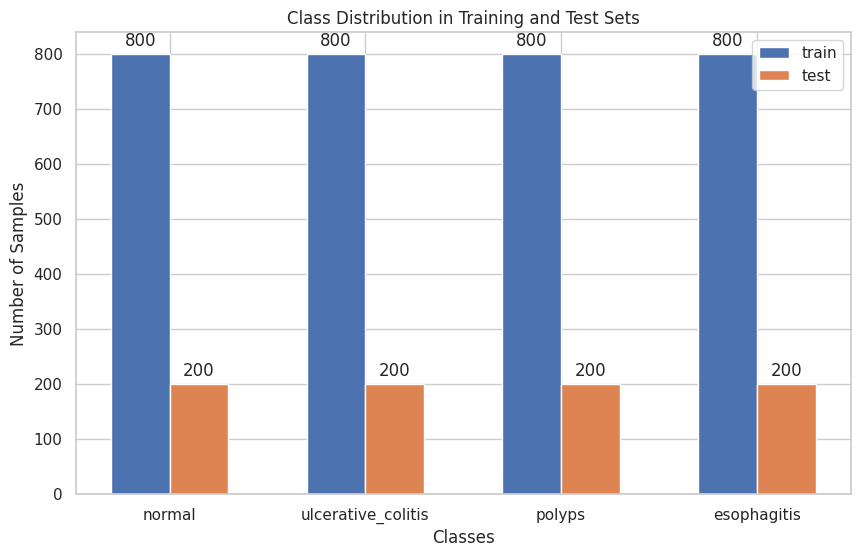

In [ ]:
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

class_names = ['normal', 'ulcerative_colitis', 'polyps', 'esophagitis']


x = np.arange(len(class_names))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, train_counts, width, label='train')
bars2 = ax.bar(x + width/2, test_counts, width, label='test')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution in Training and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()


def add_counts(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_counts(bars1)
add_counts(bars2)

plt.show()


Training Set Örnekleri:
Validation Set Örnekleri:
Test Set Örnekleri:


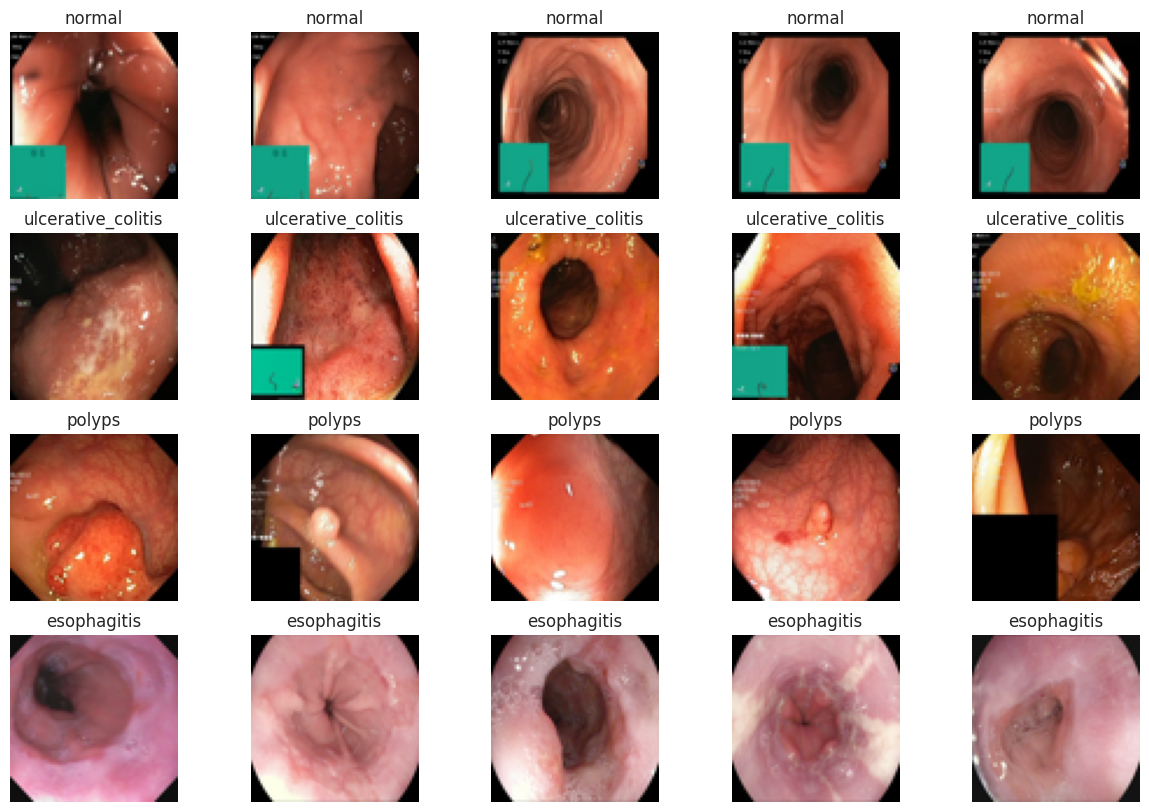

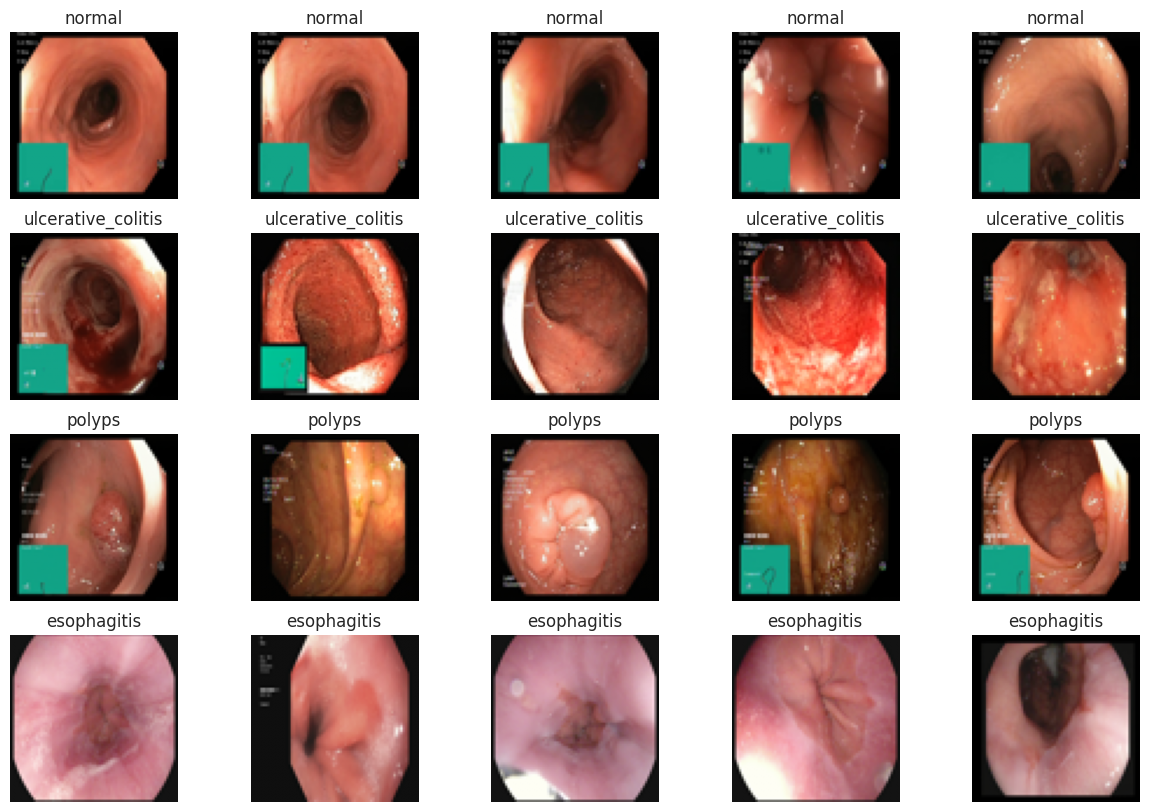

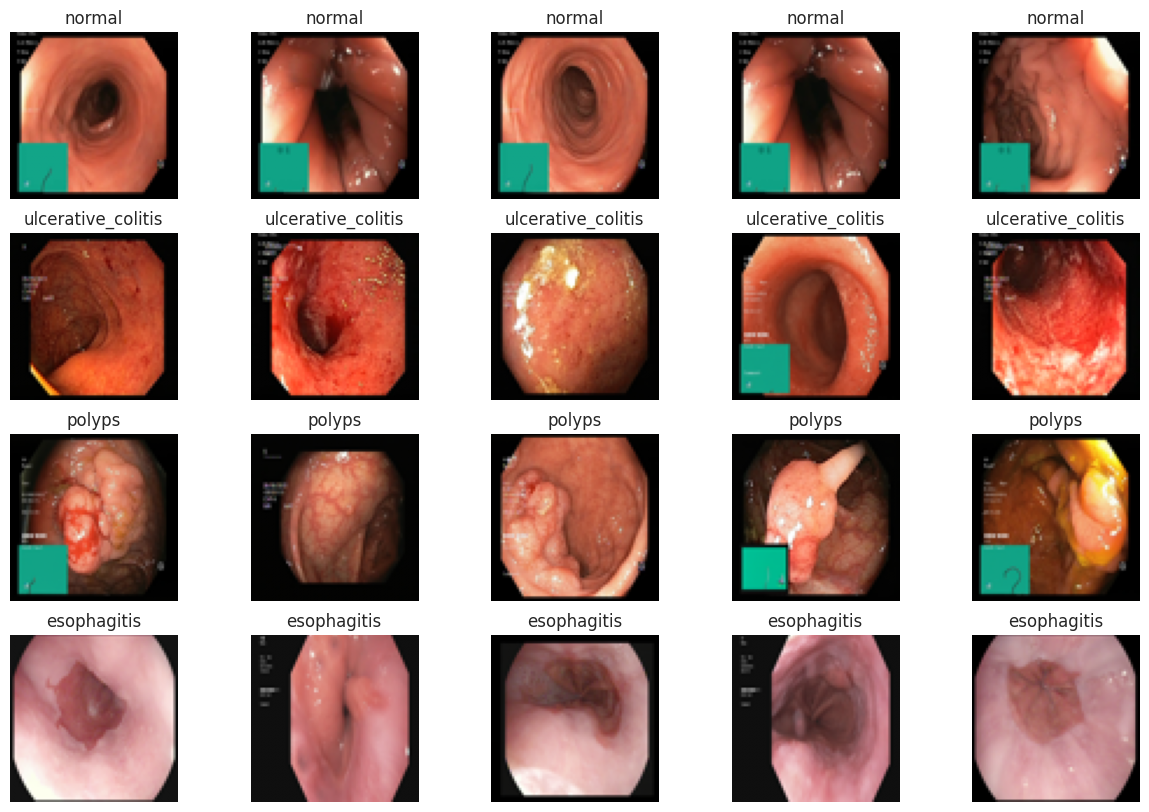

In [ ]:
def plot_sample_images(x_data, y_data, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for class_index, class_name in enumerate(class_names):
        indices = np.where(y_data == class_index)[0]
        selected_indices = np.random.choice(indices, num_samples, replace=False)

        for i, idx in enumerate(selected_indices):
            plt.subplot(len(class_names), num_samples, class_index * num_samples + i + 1)
            plt.imshow(x_data[idx])
            plt.title(class_name)
            plt.axis('off')

class_names = ['normal', 'ulcerative_colitis', 'polyps', 'esophagitis']

print("Training Set Örnekleri:")
plot_sample_images(x_train, y_train, class_names)

print("Validation Set Örnekleri:")
plot_sample_images(x_val, y_val, class_names)

print("Test Set Örnekleri:")
plot_sample_images(x_test, y_test, class_names)

plt.show()


In [ ]:
# CNN ile Modelleme

model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding="valid", input_shape=(pic_size, pic_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding="valid"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(units=128, activation='relu',
                 kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                 bias_regularizer=regularizers.L2(1e-2),
                 activity_regularizer=regularizers.L2(1e-3)),
    layers.Dropout(0.5),
    layers.Dense(units=4, activation='softmax'),  # Çok sınıflı sınıflandırma için
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 17, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_40 (Dense)            (None, 128)               1

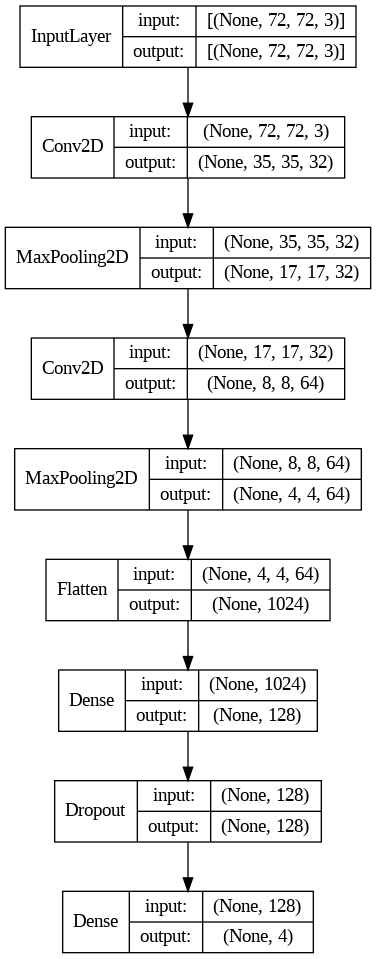

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

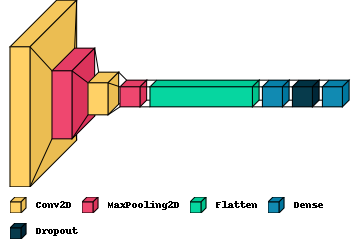

In [ ]:
visualkeras.layered_view(model, legend=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

Epoch 1/15
100/100 [==============================] - 5s 15ms/step - loss: 2.6862 - accuracy: 0.7481 - val_loss: 1.7255 - val_accuracy: 0.6445
Epoch 2/15
100/100 [==============================] - 1s 7ms/step - loss: 0.7590 - accuracy: 0.9331 - val_loss: 1.5163 - val_accuracy: 0.6025
Epoch 3/15
100/100 [==============================] - 1s 8ms/step - loss: 0.4270 - accuracy: 0.9684 - val_loss: 1.0089 - val_accuracy: 0.6515
Epoch 4/15
100/100 [==============================] - 1s 6ms/step - loss: 0.3278 - accuracy: 0.9750 - val_loss: 1.2120 - val_accuracy: 0.6930
Epoch 5/15
100/100 [==============================] - 1s 9ms/step - loss: 0.2632 - accuracy: 0.9816 - val_loss: 1.0729 - val_accuracy: 0.6385
Epoch 6/15
100/100 [==============================] - 1s 9ms/step - loss: 0.2374 - accuracy: 0.9850 - val_loss: 1.3080 - val_accuracy: 0.7150
Epoch 7/15
100/100 [==============================] - 1s 8ms/step - loss: 0.2203 - accuracy: 0.9837 - val_loss: 1.4044 - val_accuracy: 0.7375
Epoch

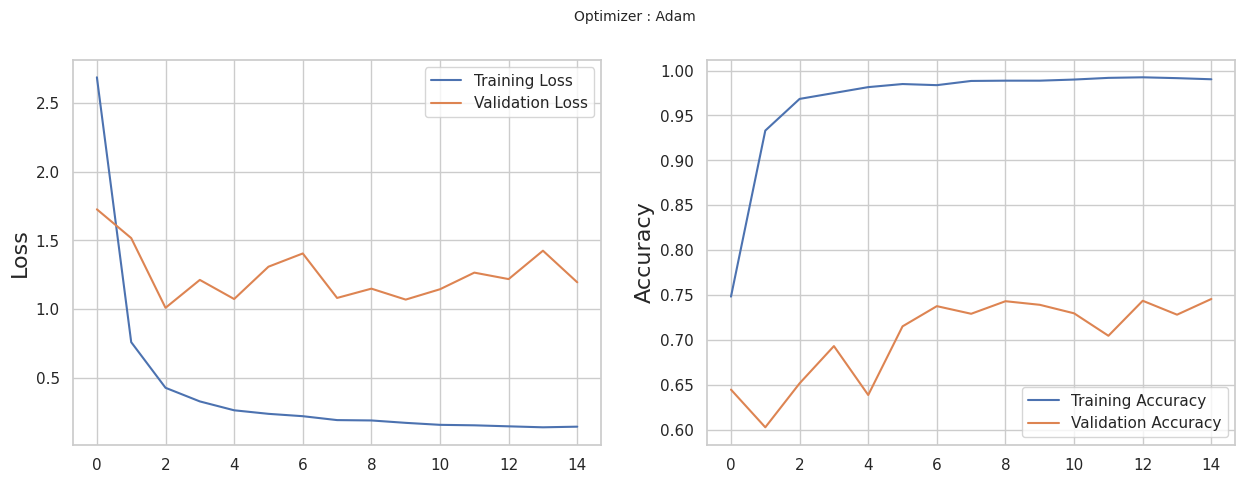

In [ ]:
def plot_history(history):
    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

25/25 [==============================] - 0s 3ms/step - loss: 1.1695 - accuracy: 0.7462
Test accuracy: 74.62%


25/25 [==============================] - 0s 2ms/step


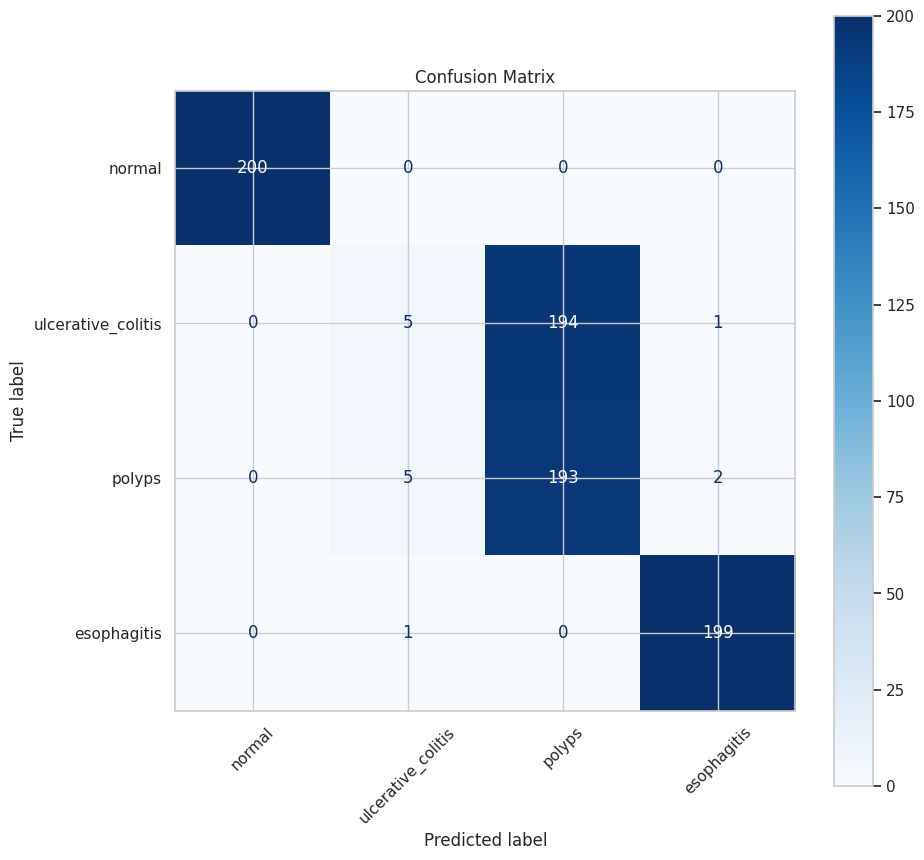

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, x_test, y_test, class_names):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['normal', 'ulcerative_colitis', 'polyps', 'esophagitis']
plot_confusion_matrix(model, x_test, y_test, class_names)

25/25 [==============================] - 0s 2ms/step
Sınıflandırma Raporu:
                    precision   recall  f1-score    support  accuracy
normal               1.000000  1.00000  1.000000  200.00000   0.74625
ulcerative_colitis   0.454545  0.02500  0.047393  200.00000       NaN
polyps               0.498708  0.96500  0.657581  200.00000       NaN
esophagitis          0.985149  0.99500  0.990050  200.00000       NaN
accuracy             0.746250  0.74625  0.746250    0.74625       NaN
macro avg            0.734600  0.74625  0.673756  800.00000       NaN
weighted avg         0.734600  0.74625  0.673756  800.00000       NaN


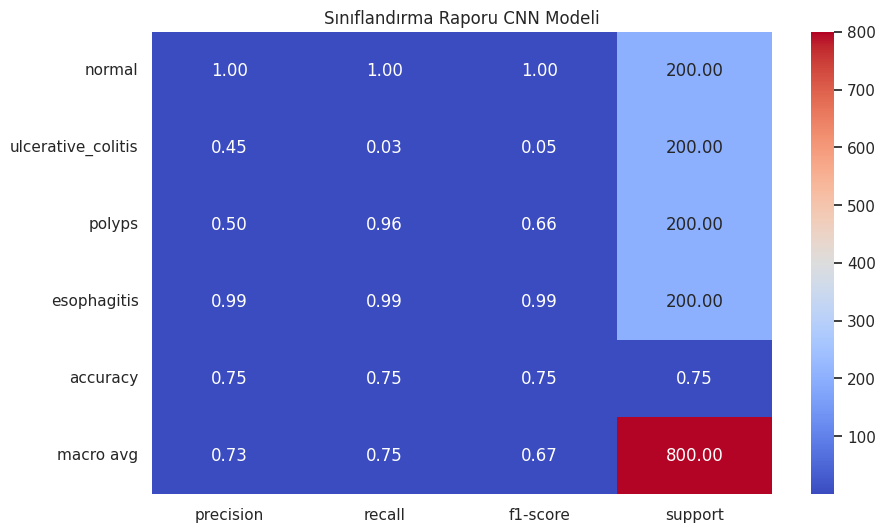

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.animation import FuncAnimation

y_pred = np.argmax(model.predict(x_test), axis=1)

report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)


report_df = pd.DataFrame(report).transpose()
report_df['accuracy'] = [accuracy] + [None] * (len(report_df) - 1)


print("Sınıflandırma Raporu:")
print(report_df)


def update_heatmap(frame, data, heatmap):
    heatmap.collections.clear()
    sns.heatmap(data.iloc[:-1, :-1], annot=True, cmap="coolwarm", fmt=".2f", ax=heatmap)


fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", fmt=".2f", ax=ax)
plt.title('Sınıflandırma Raporu CNN Modeli')

ani = FuncAnimation(fig, update_heatmap, frames=10, fargs=(report_df, ax), repeat=False)


plt.show()


##Vision Transformer

In [ ]:
!pip install tensorflow_addons

In [ ]:
# Vision Transformers(ViT) ile Modelleme

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Parametre ayarları
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # Vision Transformer için görüntü 72x72 olarak yeniden boyutlandırıldı
patch_size = 12  # Giriş görüntülerinden çıkarılacak patch'lerin boyutu
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Transformatör katmanlarının boyutu
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Son sınıflandırıcıdaki Dense katmanların boyutu


In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/archive/train",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/archive/val",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/archive/test",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 2880 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
# Multi-layer Perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Patch layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 10 X 10
Patches per image: 576
Elements per patch: 300


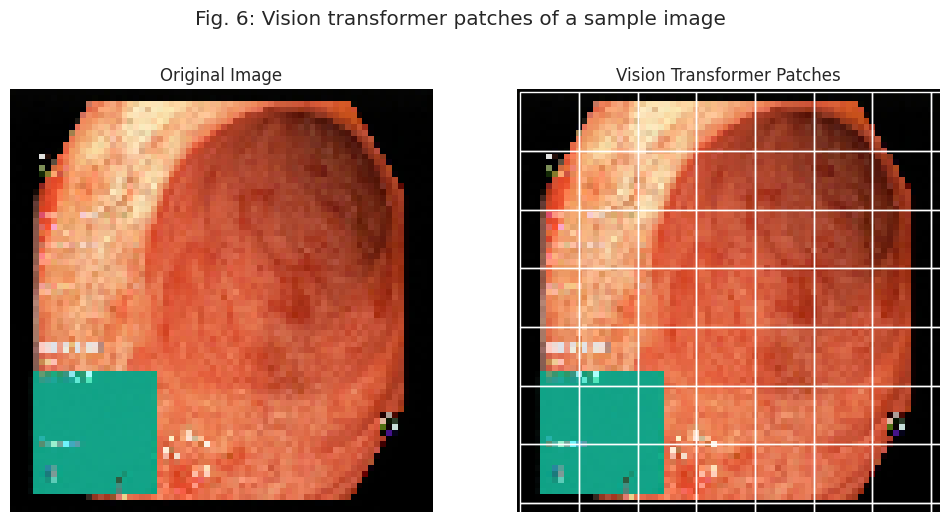

In [ ]:
"""
image_size = 240
patch_size = 10  # her bir yamanın-patch boyutu

x, _ = next(test_generator)
sample_image = x[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

# Bölünmüş yamalı görüntü
resized_image = tf.image.resize(tf.convert_to_tensor([sample_image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Original görüntü
plt.subplot(1, 2, 2)
plt.imshow(sample_image)
n_patches = int(image_size / patch_size)

for i in range(n_patches):
    for j in range(n_patches):
        rect = plt.Rectangle((j*patch_size, i*patch_size), patch_size, patch_size, linewidth=1, edgecolor='white', facecolor='none')
        plt.gca().add_patch(rect)

plt.title("Vision Transformer Patches")
plt.axis("off")

plt.suptitle("Fig. 6: Vision transformer patches of a sample image")
plt.show()"""

In [ ]:
# Patch Encoder
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
# Vision Transformer Modeli

def create_vit_classifier():
    inputs = layers.Input(shape=(image_size, image_size, 3))
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(4)(features)  # 4 sınıf olduğu için
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_generator)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


In [ ]:
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
12/12 [==============================] - 46s 3s/step - loss: 4.8848 - accuracy: 0.2722 - val_loss: 1.5259 - val_accuracy: 0.2500
Epoch 2/100
12/12 [==============================] - 31s 3s/step - loss: 1.5041 - accuracy: 0.2851 - val_loss: 1.3522 - val_accuracy: 0.4150
Epoch 3/100
12/12 [==============================] - 31s 3s/step - loss: 1.3685 - accuracy: 0.3163 - val_loss: 1.2471 - val_accuracy: 0.4500
Epoch 4/100
12/12 [==============================] - 31s 3s/step - loss: 1.1793 - accuracy: 0.4372 - val_loss: 1.2596 - val_accuracy: 0.4200
Epoch 5/100
12/12 [==============================] - 30s 3s/step - loss: 1.0158 - accuracy: 0.5226 - val_loss: 1.5166 - val_accuracy: 0.4150
Epoch 6/100
12/12 [==============================] - 32s 3s/step - loss: 0.9094 - accuracy: 0.5892 - val_loss: 1.5025 - val_accuracy: 0.5450
Epoch 7/100
12/12 [==============================] - 31s 3s/step - loss: 0.7347 - accuracy: 0.6958 - val_loss: 1.2568 - val_accuracy: 0.4850
Epoch 8/100
1

In [ ]:
test_loss, test_acc = vit_classifier.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc}")

4/4 [==============================] - 9s 3s/step - loss: 0.4668 - accuracy: 0.8225
Final Test Accuracy: 0.8224999904632568


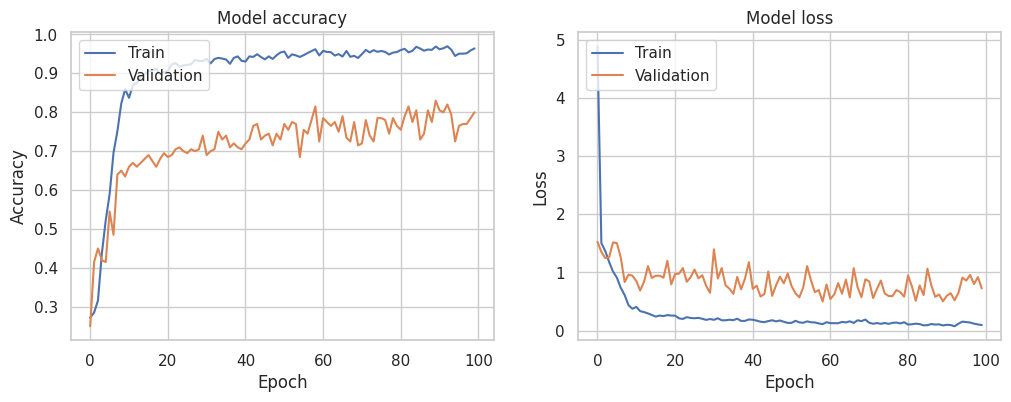

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(vit_history)


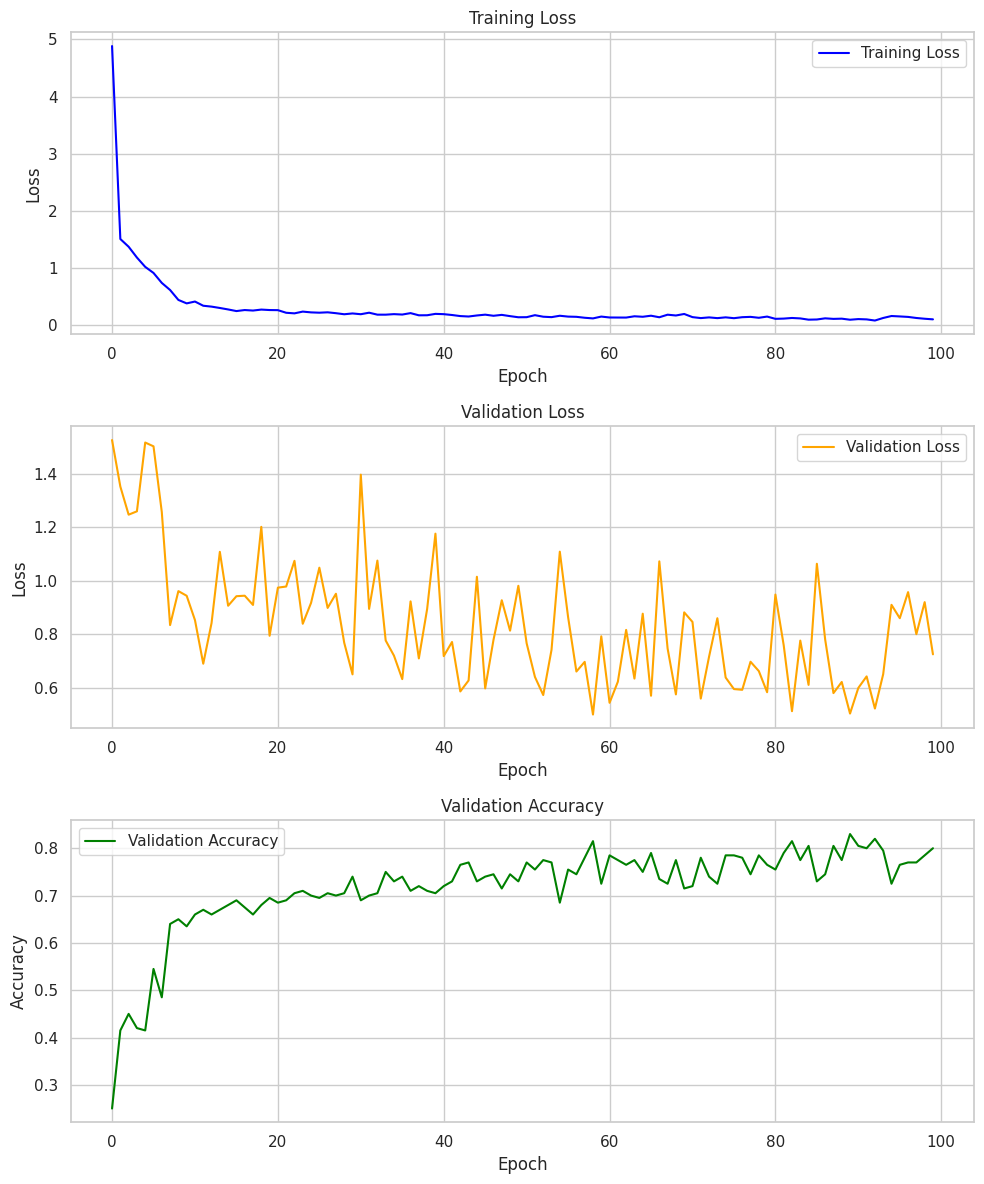

In [ ]:

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].plot(vit_history.history['loss'], label='Training Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

axes[1].plot(vit_history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()

axes[2].plot(vit_history.history['val_accuracy'], label='Validation Accuracy', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Validation Accuracy')
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:

log_history = pd.DataFrame({
    'epoch': range(1, len(vit_history.history['loss']) + 1),
    'loss': vit_history.history['loss'],
    'learning_rate': [0.001] * len(vit_history.history['loss']),
    'eval_loss': vit_history.history['val_loss'],
    'eval_accuracy': vit_history.history['val_accuracy'],
    'eval_f1': [0] * len(vit_history.history['loss']),
    'eval_precision': [0] * len(vit_history.history['loss']),
    'eval_recall': [0] * len(vit_history.history['loss']),
    'eval_runtime': [0] * len(vit_history.history['loss']),
    'eval_samples': [0] * len(vit_history.history['loss']),
    'step': [i * 850 for i in range(1, len(vit_history.history['loss']) + 1)]
})

log_history = log_history.fillna(0)
log_history = log_history.groupby(['epoch']).sum()

first_five = log_history.head(5)
last_five = log_history.tail(5)

first_five_style = first_five.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('font-size', '15px'), ('text-align', 'center')]},
     {'selector': 'tbody td', 'props': [('font-size', '15px')]}]
).set_properties(**{'text-align': 'center'}).set_caption("First Five Epochs")

last_five_style = last_five.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('font-size', '15px'), ('text-align', 'center')]},
     {'selector': 'tbody td', 'props': [('font-size', '15px')]}]
).set_properties(**{'text-align': 'center'}).set_caption("Last Five Epochs")

display(first_five_style)
display(last_five_style)


4/4 [==============================] - 9s 2s/step


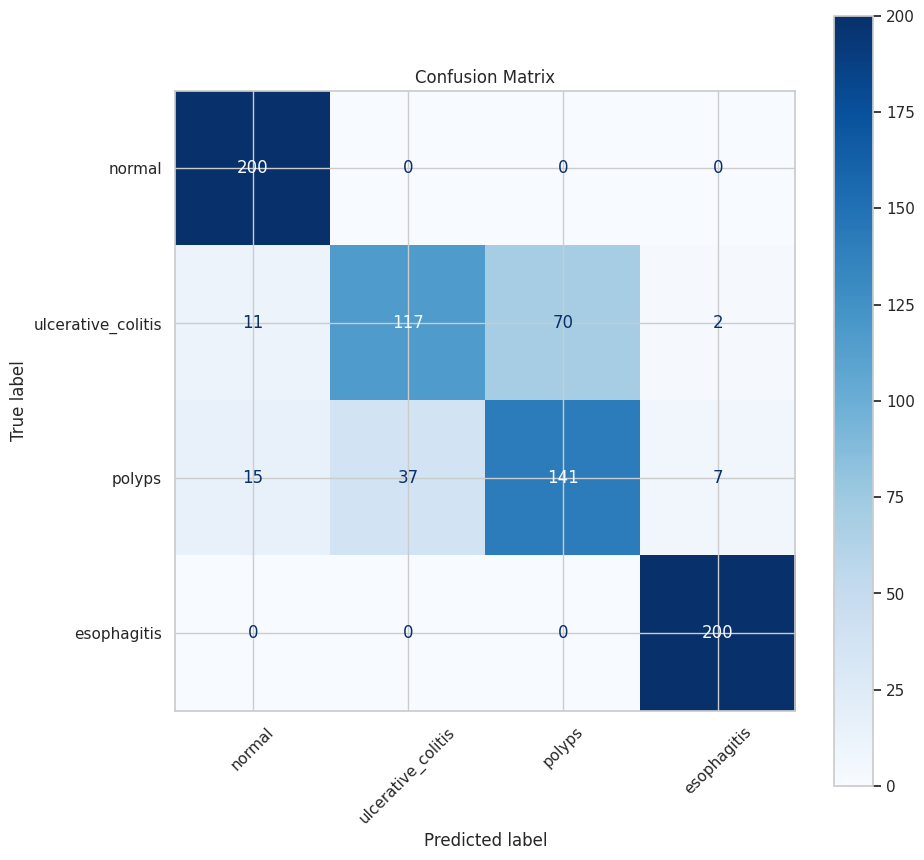

In [ ]:
# Confusion Matrix - Karmaşıklık Matrisi

def plot_confusion_matrix(model, test_generator, class_names):

    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())

    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['normal', 'ulcerative_colitis', 'polyps', 'esophagitis']

plot_confusion_matrix(vit_classifier, test_generator, class_names)


Training Set Predictions:
1/1 [==============================] - 0s 29ms/step


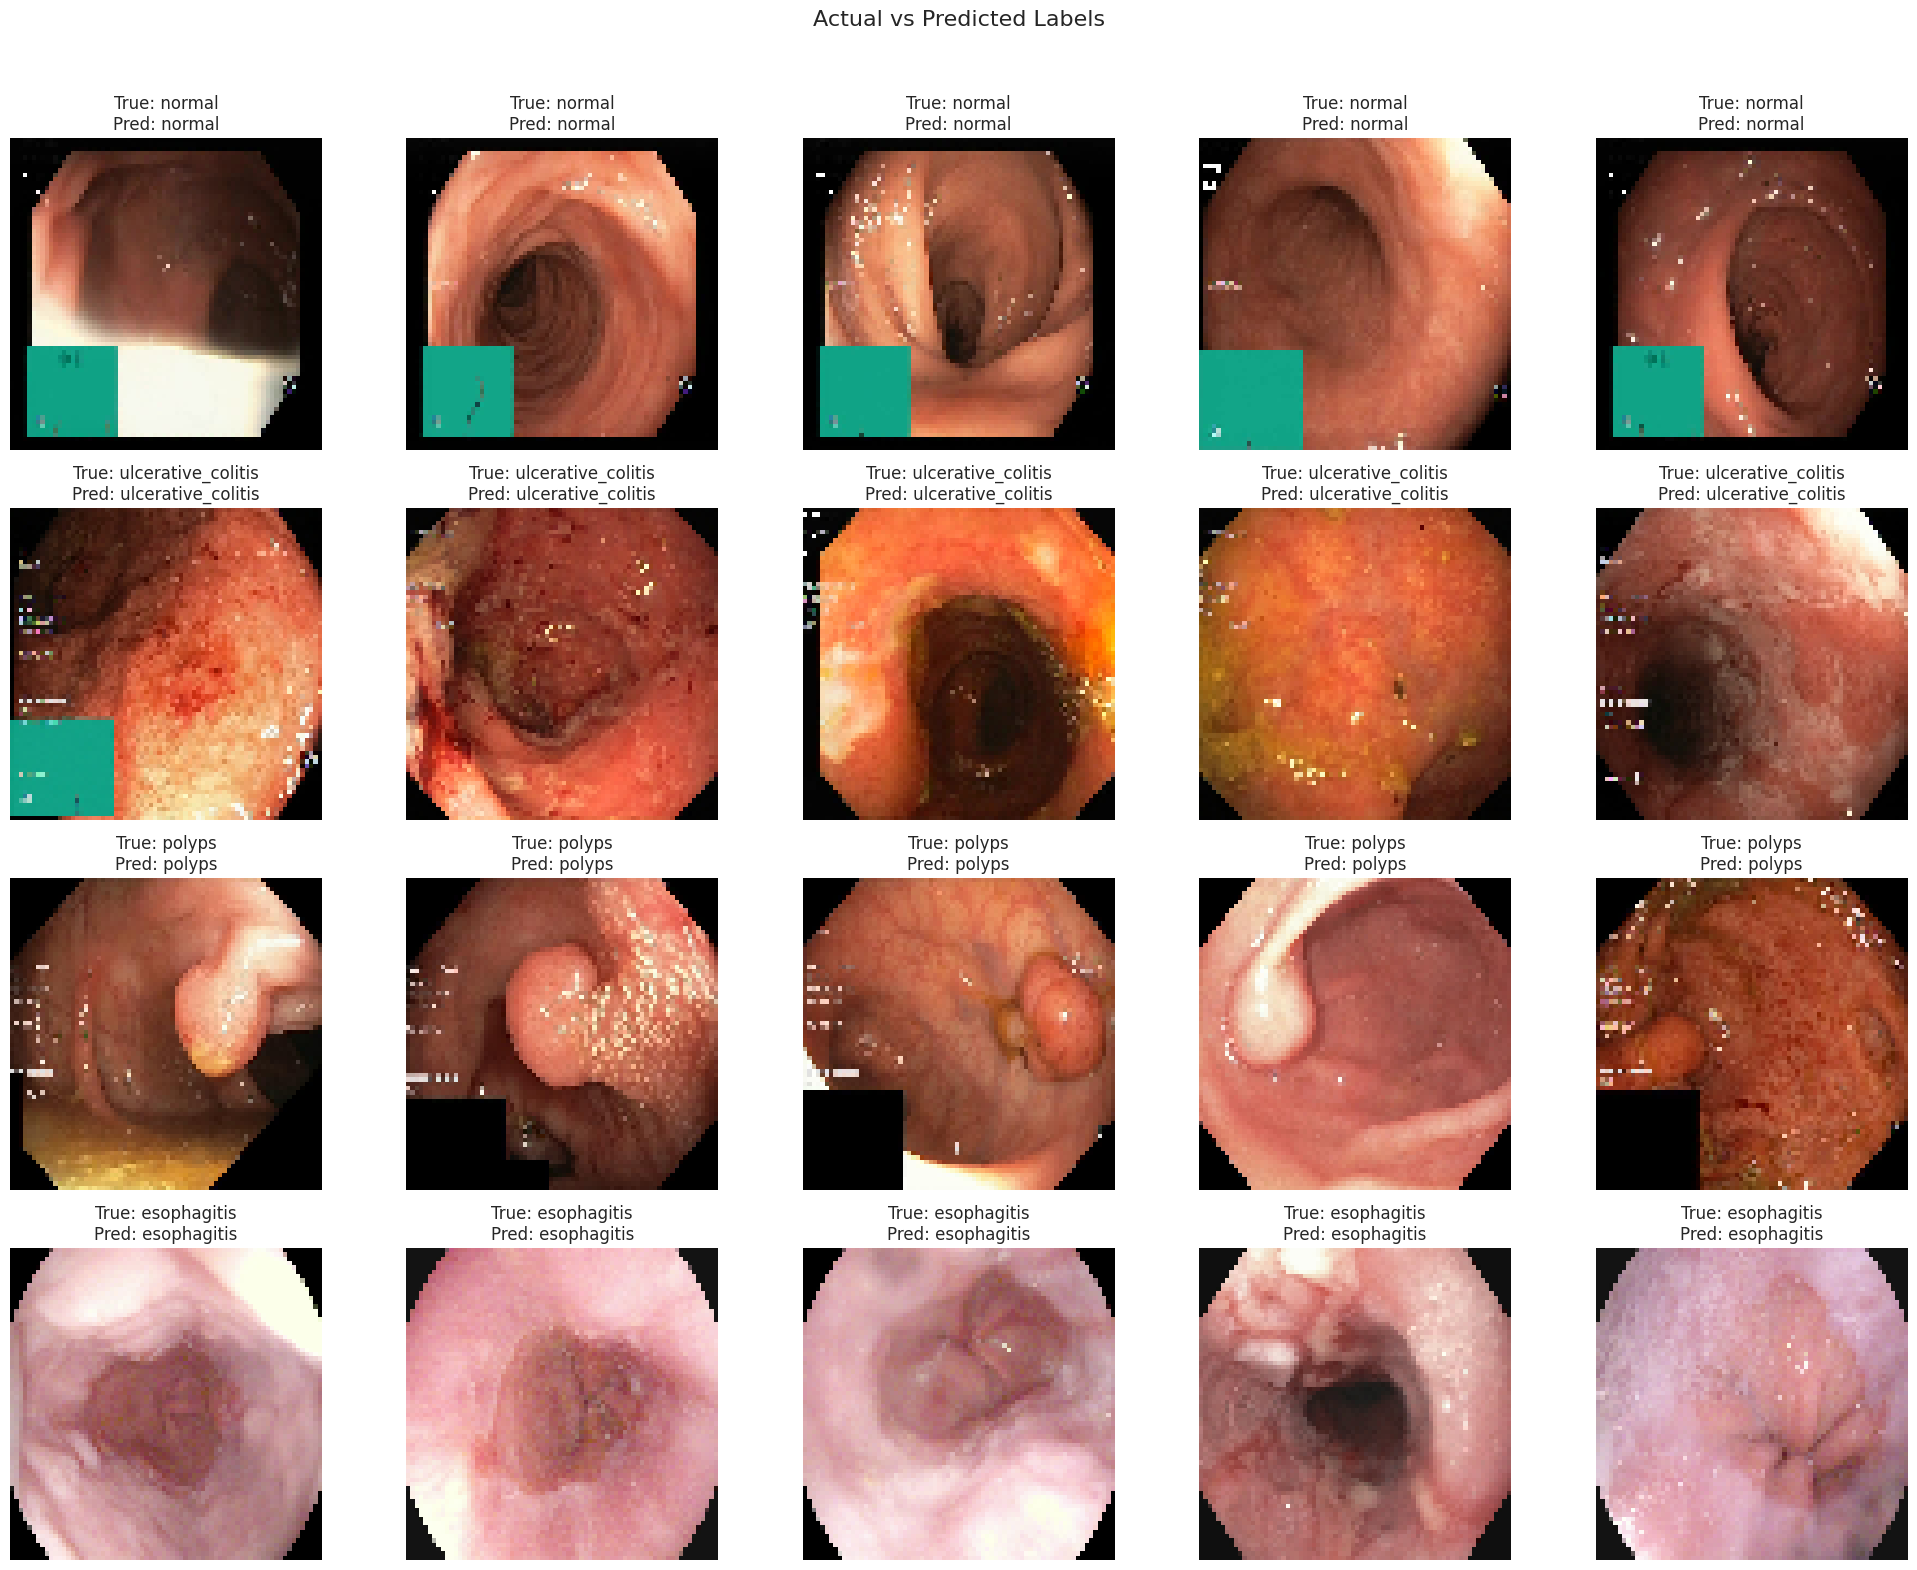

Validation Set Predictions:
1/1 [==============================] - 0s 30ms/step


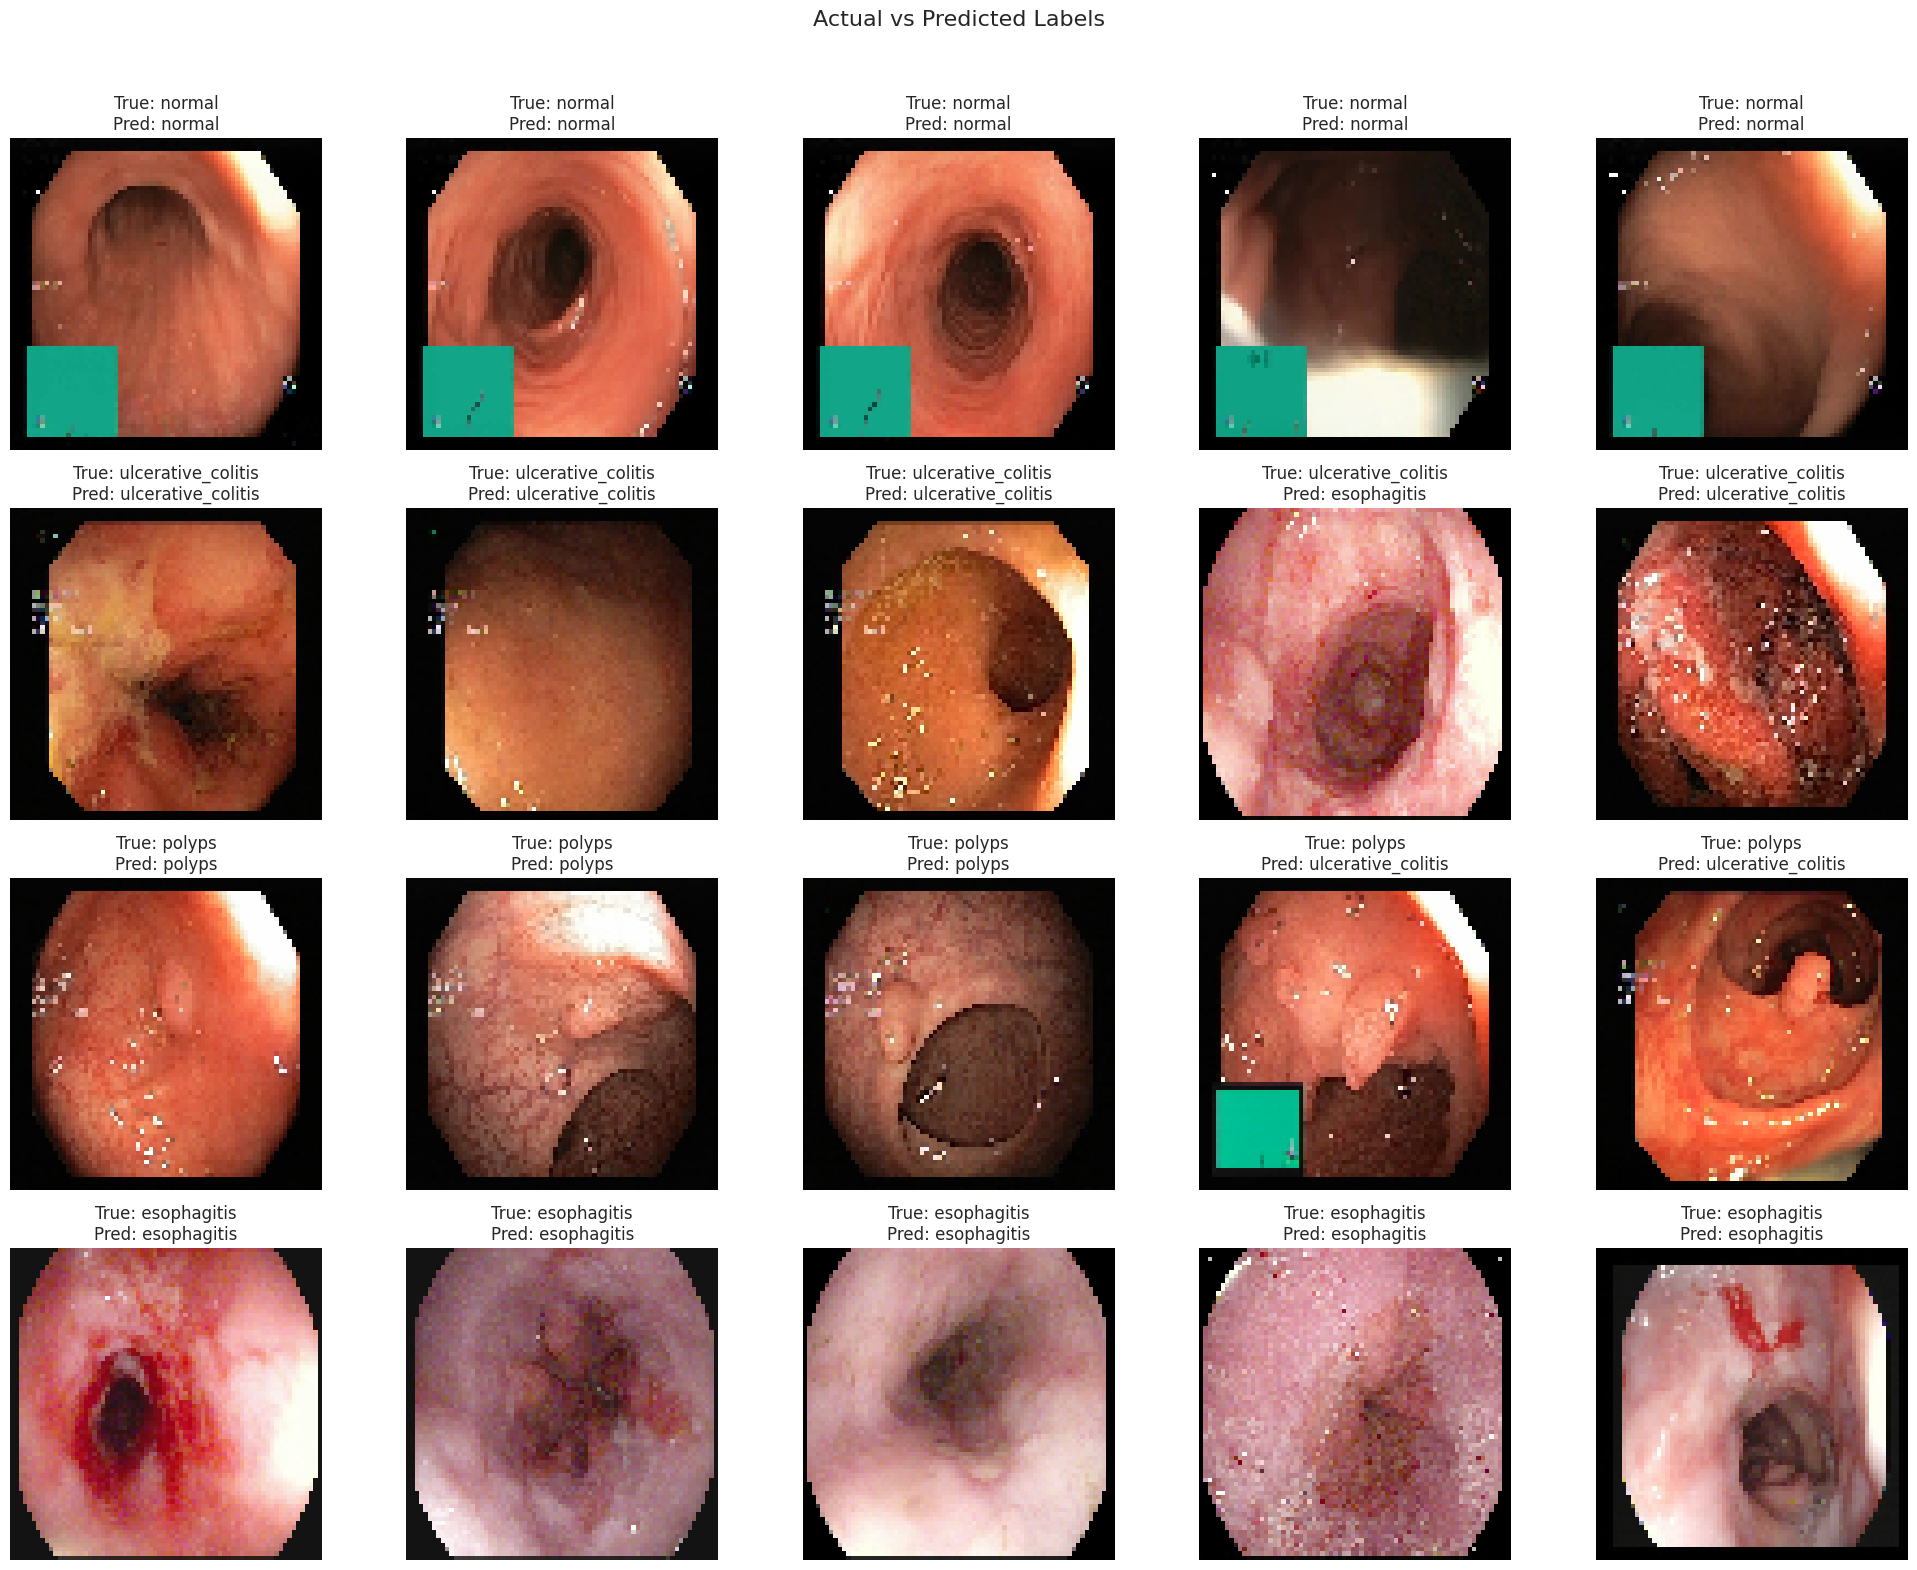

Test Set Predictions:
1/1 [==============================] - 0s 30ms/step


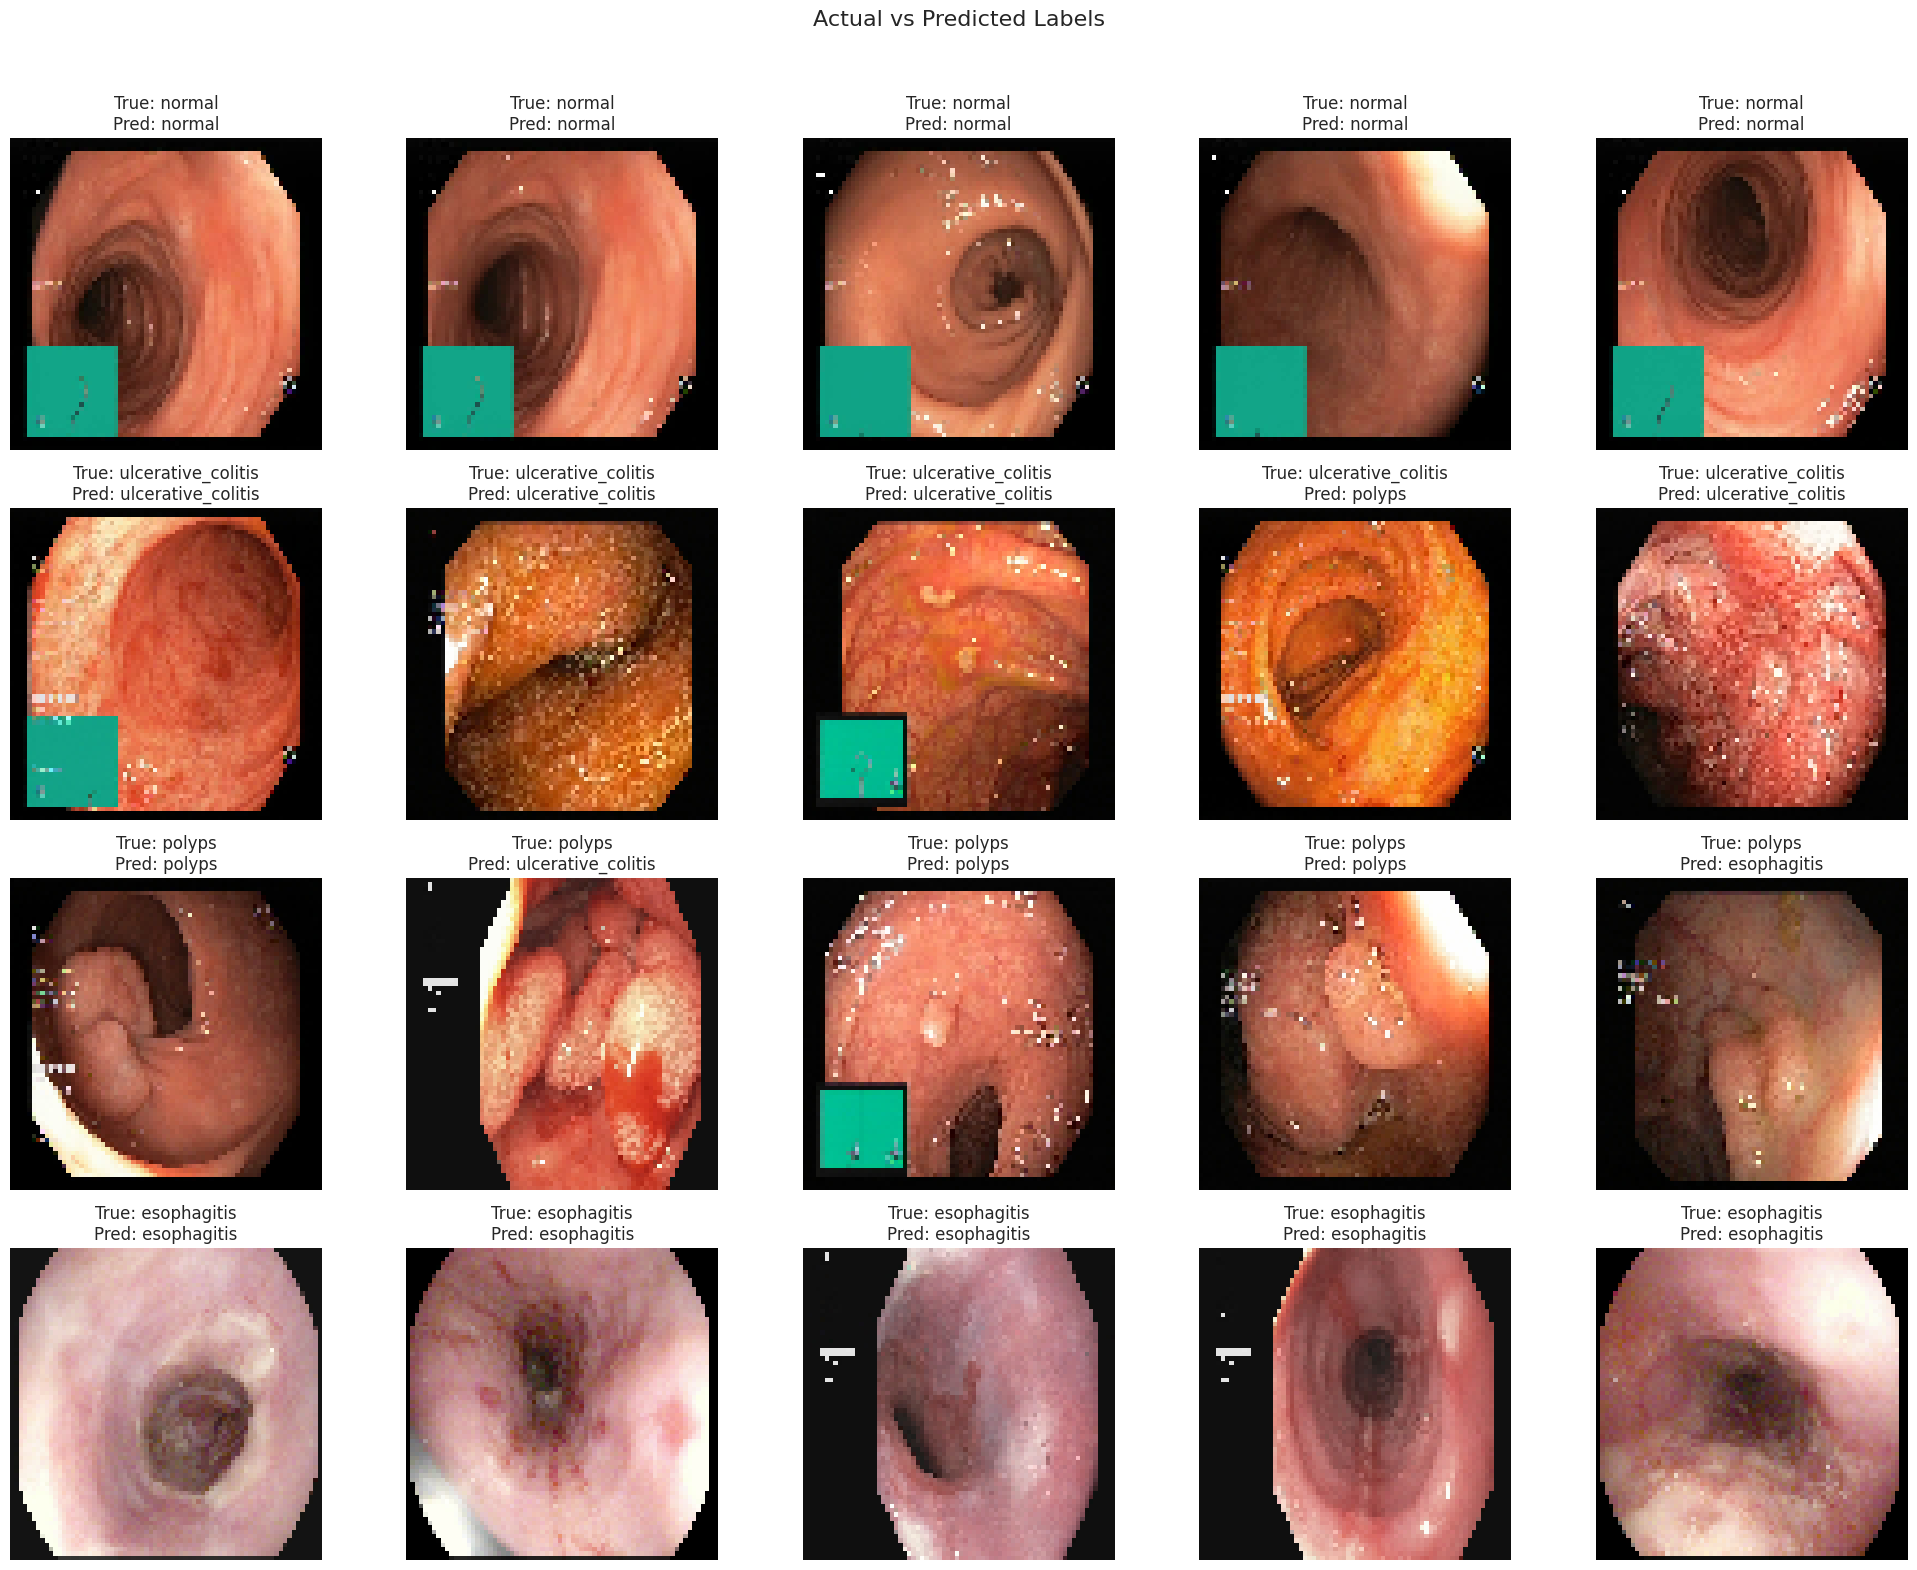

In [ ]:

def plot_predictions(generator, model, class_names, num_samples=5):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples * 4, len(class_names) * 4))
    fig.suptitle(f'Actual vs Predicted Labels', fontsize=16)

    for class_index, class_name in enumerate(class_names):
        images, labels = next(generator)
        class_images = images[labels == class_index][:num_samples]

        for i, img in enumerate(class_images):
            img_array = np.expand_dims(img, axis=0)
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]

            ax = axes[class_index, i]
            ax.imshow(img)
            ax.set_title(f"True: {class_name}\nPred: {class_names[predicted_class]}")
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

class_names = ['normal', 'ulcerative_colitis', 'polyps', 'esophagitis']


print("Training Set Predictions:")
plot_predictions(train_generator, vit_classifier, class_names, num_samples=5)

print("Validation Set Predictions:")
plot_predictions(val_generator, vit_classifier, class_names, num_samples=5)

print("Test Set Predictions:")
plot_predictions(test_generator, vit_classifier, class_names, num_samples=5)


4/4 [==============================] - 9s 2s/step
y_true shape: (800,)
y_pred shape: (800,)
Classification Report:
                      precision  recall  f1-score   support  accuracy
0_normal               0.884956  1.0000  0.938967  200.0000    0.8225
1_ulcerative_colitis   0.759740  0.5850  0.661017  200.0000       NaN
2_polyps               0.668246  0.7050  0.686131  200.0000       NaN
3_esophagitis          0.956938  1.0000  0.977995  200.0000       NaN
accuracy               0.822500  0.8225  0.822500    0.8225       NaN
macro avg              0.817470  0.8225  0.816028  800.0000       NaN
weighted avg           0.817470  0.8225  0.816028  800.0000       NaN


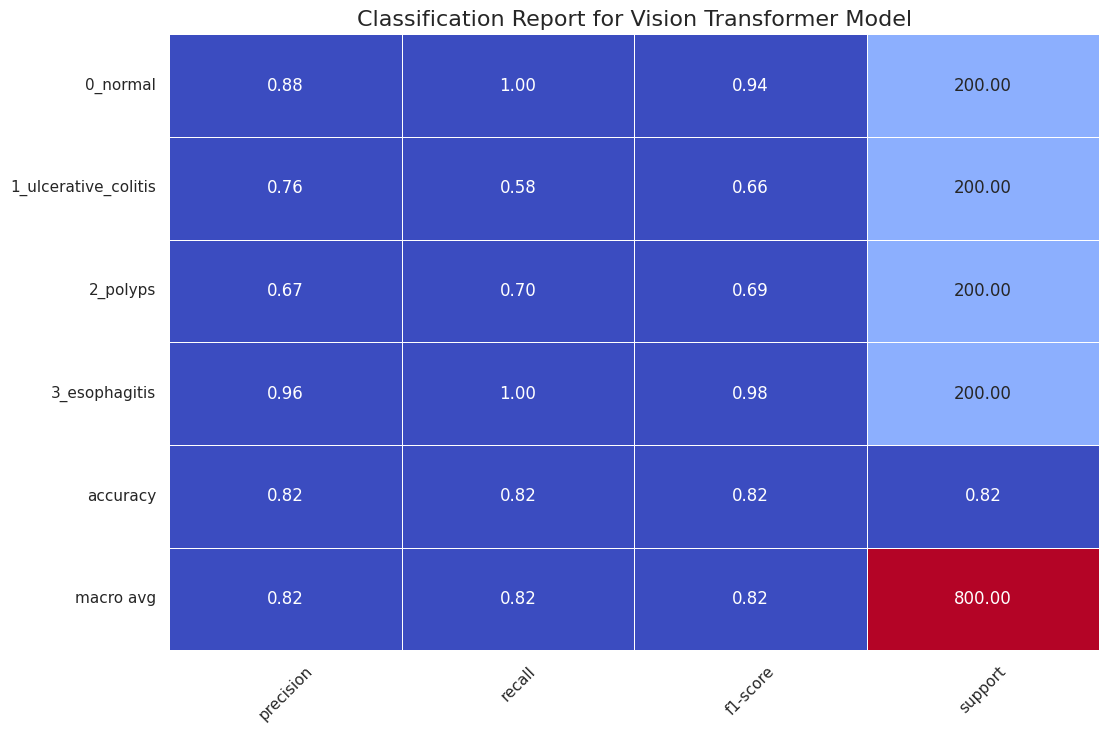

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_true = test_generator.classes
y_pred_probs = vit_classifier.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f'y_true shape: {y_true.shape}')
print(f'y_pred shape: {y_pred.shape}')

class_names = list(test_generator.class_indices.keys())


report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
accuracy = accuracy_score(y_true, y_pred)

report_df = pd.DataFrame(report).transpose()
report_df['accuracy'] = [accuracy] + [None] * (len(report_df) - 1)

print("Classification Report:")
print(report_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

heatmap = sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", fmt=".2f", cbar=False, linewidths=.5)
heatmap.set_title('Classification Report for Vision Transformer Model', fontsize=16) #ViT Model için Sınıflandırma Raporu

plt.xticks(rotation=45)
plt.show()


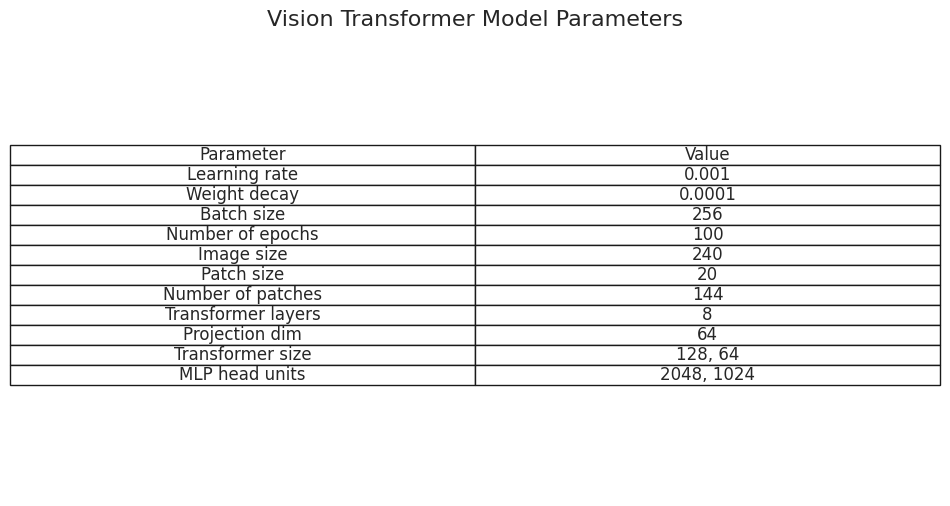

In [ ]:
# Vision Transformer model içinde kullanılan parametreler

params = {
    "Parameter": [
        "Learning rate",
        "Weight decay",
        "Batch size",
        "Number of epochs",
        "Image size",
        "Patch size",
        "Number of patches",
        "Transformer layers",
        "Projection dim",
        "Transformer size",
        "MLP head units"
    ],
    "Value": [
        0.001,  # Learning rate - öğrenme hızı
        0.0001,  # Weight decay - ağırlık bozunumu
        256,  # Batch size - toplu işlem sayısı
        100,  # Number of epochs - epochs sayısı
        240,  # Image size - görüntü boyutu
        20,  # Patch size - yama, parçalara bölünen görüntülerin boyutur
        (240 // 20) ** 2,  # Number of patches
        8,  # Transformer layers - transformer katmanları
        64,  # Projection dim - yine boyut
        "128, 64",  # Transformer size - transformer boyutu
        "2048, 1024"  # MLP head units - MLP başlık birimleri
    ]
}


params_df = pd.DataFrame(params)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

table = plt.table(cellText=params_df.values, colLabels=params_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)


plt.axis('off')
plt.title('Vision Transformer Model Parameters', fontsize=16)
plt.show()


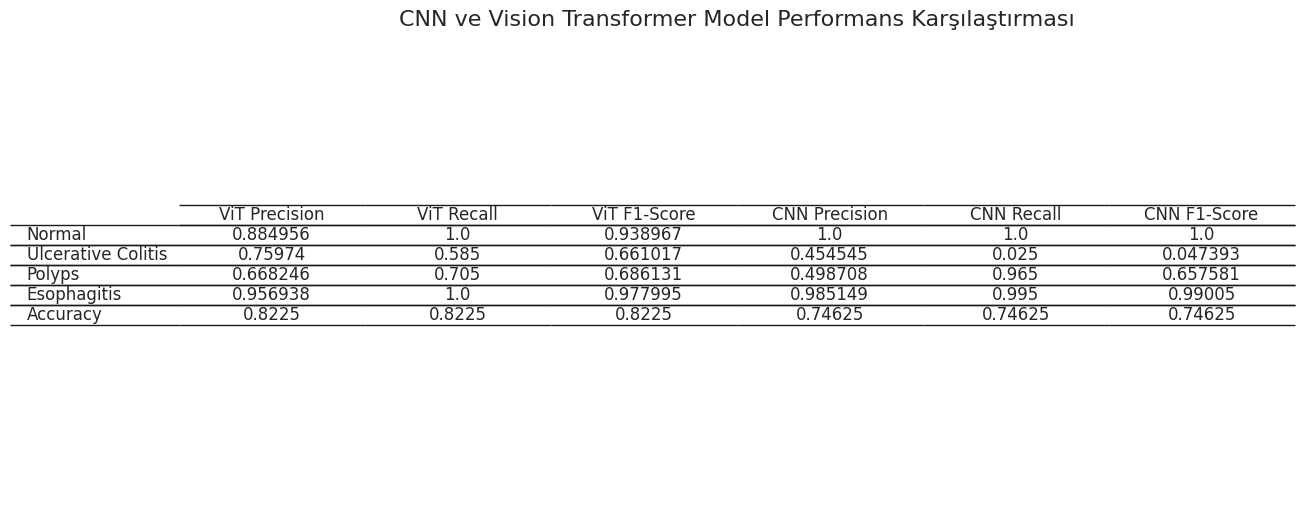

In [ ]:
from matplotlib.animation import FuncAnimation


vit_data = {
    "Class": ["Normal", "Ulcerative Colitis", "Polyps", "Esophagitis", "Accuracy"],
    "ViT Precision": [0.884956, 0.759740, 0.668246, 0.956938, 0.822500],
    "ViT Recall": [1.0000, 0.5850, 0.7050, 1.0000, 0.822500],
    "ViT F1-Score": [0.938967, 0.661017, 0.686131, 0.977995, 0.822500]
}

cnn_data = {
    "Class": ["Normal", "Ulcerative Colitis", "Polyps", "Esophagitis", "Accuracy"],
    "CNN Precision": [1.000000, 0.454545, 0.498708, 0.985149, 0.746250],
    "CNN Recall": [1.00000, 0.02500, 0.96500, 0.99500, 0.746250],
    "CNN F1-Score": [1.000000, 0.047393, 0.657581, 0.990050, 0.746250]
}

vit_df = pd.DataFrame(vit_data)
cnn_df = pd.DataFrame(cnn_data)

comparison_df = pd.merge(vit_df, cnn_df, on="Class")
comparison_df.set_index("Class", inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

def update_table(frame, table, data):
    table._cells.clear()
    table.update_celld()
    for key, cell in table.get_celld().items():
        cell.set_text_props(text=data.values[key[0], key[1]])
        cell.set_edgecolor('black')
        if key[0] == 0:
            cell.set_facecolor('#f2f2f2')
        else:
            value = data.values[key[0], key[1]]
            if isinstance(value, (int, float)):
                color = plt.cm.RdYlGn(value) if key[1] % 2 == 0 else plt.cm.YlOrRd(value)
                cell.set_facecolor(color)
            else:
                cell.set_facecolor('white')

the_table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns, rowLabels=comparison_df.index, cellLoc='center', loc='center', edges='horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.2)

ani = FuncAnimation(fig, update_table, frames=10, fargs=(the_table, comparison_df), repeat=False)

plt.title('CNN ve Vision Transformer Model Performans Karşılaştırması', fontsize=16)
plt.show()
